# ConvNet Abstraction

## Overview

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from typing import Tuple

from dataclasses import dataclass

if '' in sys.path:
    sys.path.remove('')

module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

print(sys.path)

import networkx as nx

from graphPlot import drawGraph
from const import *

plt.rcParams['figure.figsize'] = [10, 10]
print(plt.rcParams['figure.figsize'])

['/home/shared/anaconda3/lib/python36.zip', '/home/shared/anaconda3/lib/python3.6', '/home/shared/anaconda3/lib/python3.6/lib-dynload', '/home/peng/.local/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/peng/.ipython', '/home/peng/git/convnet-abstraction/python']
=== MXNet is using gpu(0) ===
[10.0, 10.0]


## DataAugmentation

Let's do a small experiment, here is an augmentation in python

In [3]:

import aug2conv
from mxnet.ndarray import NDArray
from mxnet.gluon.data import DataLoader
from mxnet.gluon.nn import Sequential

data = aug2conv.getData()

imgs: NDArray
imgs, ls = next(data.__iter__())

(10, 10)


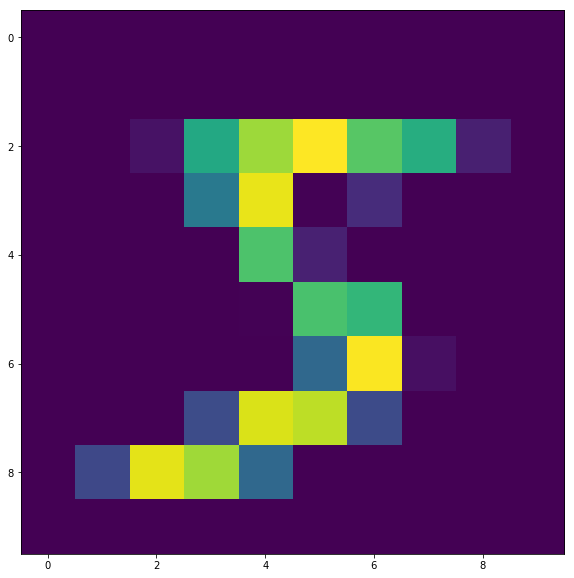

In [4]:
img1 = imgs[0].squeeze(axis=(0,))
print(img1.shape)
plt.imshow(img1.asnumpy())

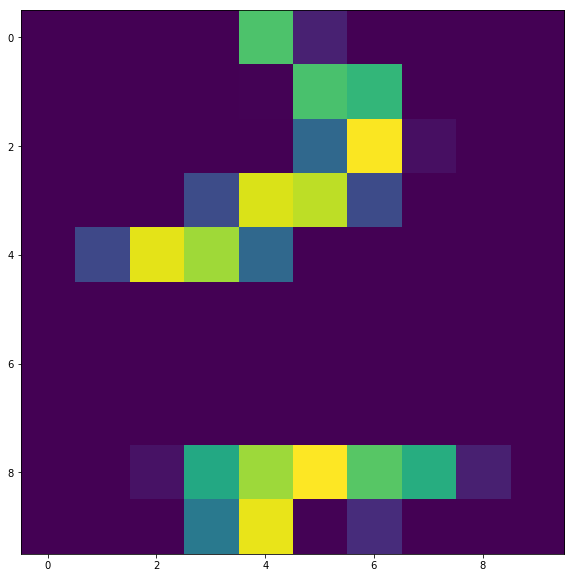

In [5]:

auged = img1.copy()

auged = aug2conv.shiftY(auged, 6)
plt.imshow(auged.asnumpy())

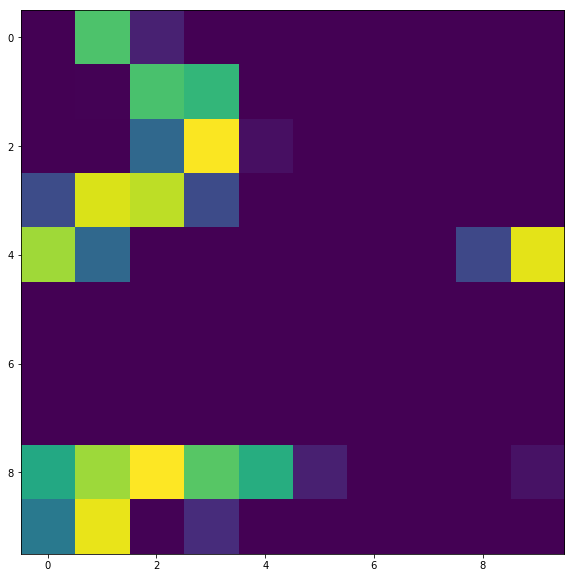

In [6]:
auged = aug2conv.shiftX(auged, 7)
plt.imshow(auged.asnumpy())

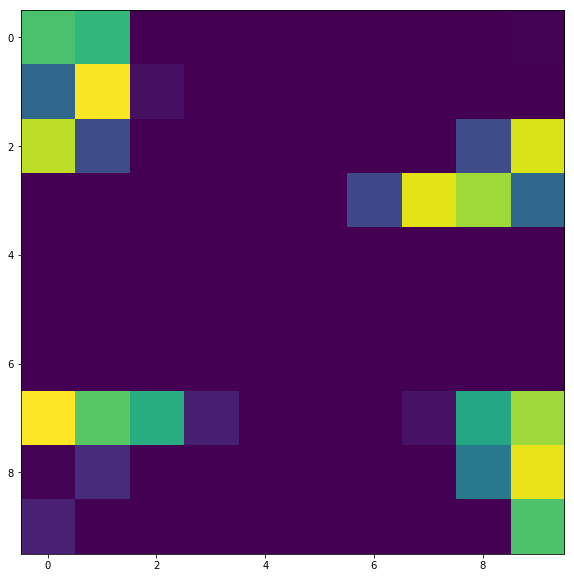

In [7]:
augmenter = aug2conv.Augmenter(img1)
auggedUp = augmenter.aug1(img1)
plt.imshow(auggedUp[55, :, :].asnumpy())

In [8]:

from mxnet import autograd, initializer
import mxnet.gluon as glu
from pathlib import Path

lossFn = glu.loss.SoftmaxCrossEntropyLoss()

In [9]:

@dataclass
class Skip(glu.HybridBlock):

    def __init__(self, layers: Tuple):
        super(Skip, self).__init__()
        self.delegate = glu.nn.HybridSequential()
        self.delegate.add(*layers)

    def getLayers(self):
        return list(self.delegate)

    def hybrid_forward(self, F, x, *args, **kwargs):
        r = self.delegate.forward(x, *args)
        return r + x.reshape(r.shape)

    def __hash__(self):
        return hash(self.delegate)

In [10]:
# Build a feed-forward network
# this goofy-looking skip architecture is from:
# [1] Y. Li and Y. Yuan, “Convergence Analysis of Two-layer Neural Networks with ReLU Activation,” no. Nips, pp. 1–11, 2017.
# designed to break symmetry

def newModel() -> glu.nn.HybridSequential:
    model = glu.nn.HybridSequential()
    # with model.name_scope():
    model.add(
        Skip((
            glu.nn.Dense(100),
        )),
        glu.nn.Activation('relu'),
        # Skip((
        #     glu.nn.Dense(100),
        # )),
        # glu.nn.Activation('relu'),
        glu.nn.Dense(10)
    )

    # init = initializer.Uniform()
    init = initializer.Zero()
    model.initialize(ctx=CTX, init=init)
    return model

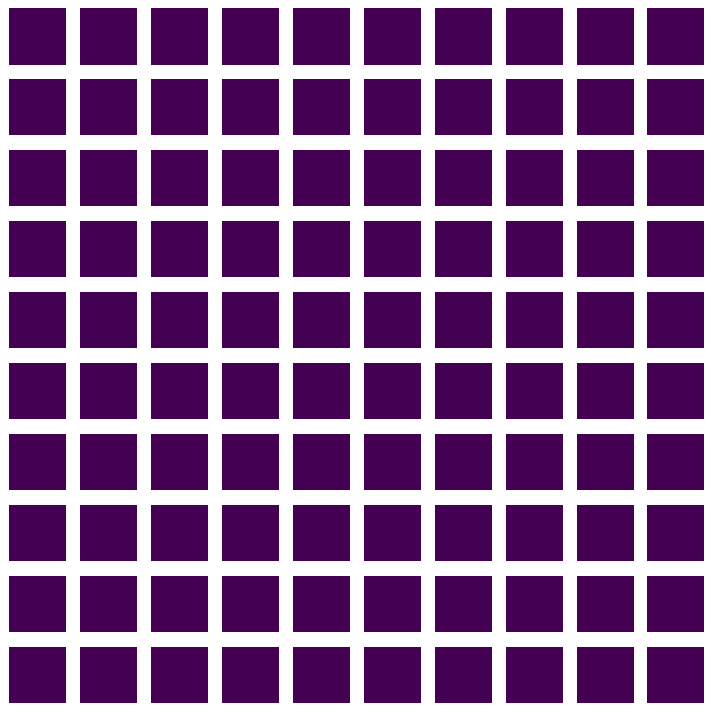

In [11]:

import utils.helper

model = newModel()
model.forward(imgs.as_in_context(CTX))

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

In [12]:
def train(
        name: str,
        loader: DataLoader = data,
        lossTarget=0.15,
        maxEpochs=100,
        aug=lambda v: v
) -> Sequential:
    model = newModel()

    filePath = f"{os.getcwd()}/{MODEL_CHKPNT}/{name}.model"

    try:
        model.load_parameters(filePath)
        print(f">> model loaded from: {filePath}")
    except Exception as ee:
        print(f">> model being learned from scratch: {filePath}")

        optimizer = glu.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

        # cc = 0
        for epoch in range(maxEpochs):
            sumLoss = 0
            for imgs, labels in loader:
                # print(f"loading batch {cc} - of {imgs.shape[0]}")
                # cc += 1
                imgs = imgs.squeeze(axis=(1,))

                imgs, labels = aug((imgs, labels))
                imgs = imgs.as_in_context(CTX)
                labels = labels.as_in_context(CTX)

                with autograd.record():
                    output = model.forward(imgs)
                    loss = lossFn(output, labels)

                loss.backward()
                sumLoss += loss.mean().asscalar()

                optimizer.step(imgs.shape[0] / 2)

            else:
                print(f"Training loss: {sumLoss / len(loader)}")

            if sumLoss / len(loader) <= lossTarget:
                break

        os.makedirs(Path(filePath).parent, exist_ok=True)
        model.save_parameters(filePath)
        print(f">>> model saved to: {filePath}")

    return model

>> model being learned from scratch: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/raw.model
Training loss: 1.0069969582722893
Training loss: 0.48722828259822654
Training loss: 0.4320364905032776
Training loss: 0.4056892123923246
Training loss: 0.3871459853626899
Training loss: 0.3716099742037465
Training loss: 0.3576274906664388
Training loss: 0.344655054432751
Training loss: 0.33255375370081425
Training loss: 0.3211603899087225
Training loss: 0.3104682239586674
Training loss: 0.300512069451021
Training loss: 0.29112012815405564
Training loss: 0.28224917518685877
Training loss: 0.273894113516296
Training loss: 0.2660123241533126
Training loss: 0.25853858961026743
Training loss: 0.25142546811266175
Training loss: 0.24467411150595844
Training loss: 0.2383568350559295
Training loss: 0.23244423045318074
Training loss: 0.22691364704109013
Training loss: 0.22169269149753648
Training loss: 0.21681141120586186
Training loss: 0.21221168230631268
Training loss: 0.20789222967729512

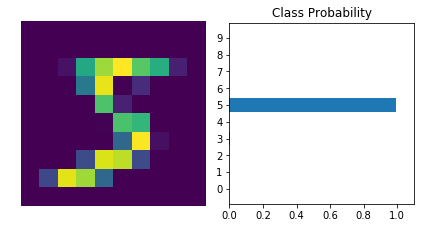

In [13]:

model = train("raw")

logits = model.forward(imgs.as_in_context(CTX))
ps = mx.ndarray.softmax(logits, axis=1)

utils.helper.view_classify(imgs[0], ps[0])

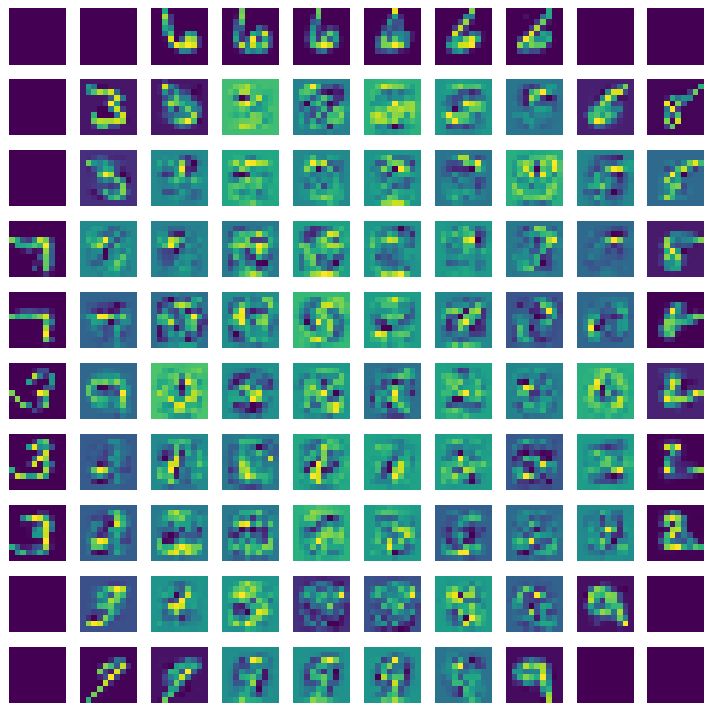

In [14]:

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

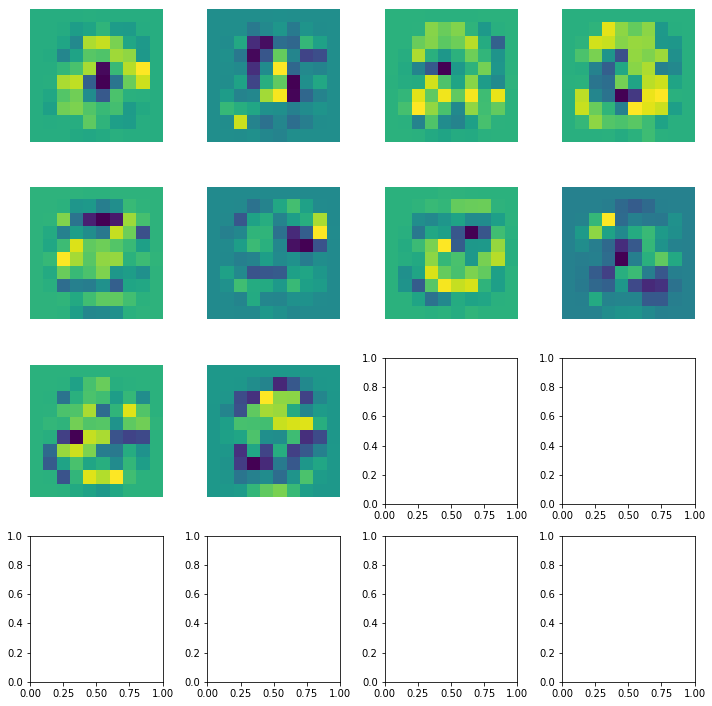

In [15]:

fc3 = model[len(model) - 1]
utils.helper.viewFCWeights(fc3)

In [16]:

# now let's enable augmentation

augModel = train("aug", aug=augmenter.augFirstTuple)

>> model being learned from scratch: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/aug.model
Training loss: 2.2961864941664087
Training loss: 2.2730962406597666
Training loss: 2.250979169472448
Training loss: 2.2294193637142303
Training loss: 2.2081029922214905
Training loss: 2.186572565325796
Training loss: 2.1642693613510904
Training loss: 2.140903665630548
Training loss: 2.117008843147424
Training loss: 2.093689742436541
Training loss: 2.0719969408598535
Training loss: 2.051450609747789
Training loss: 2.032167647979153
Training loss: 2.0148806679985927
Training loss: 1.9997743083787625
Training loss: 1.986518619347737
Training loss: 1.9751357757079322
Training loss: 1.965009570248854
Training loss: 1.956337595608697
Training loss: 1.9487528444162563
Training loss: 1.9421769697020557
Training loss: 1.9362045802287202
Training loss: 1.9307479004044015
Training loss: 1.925856471760695
Training loss: 1.9212705158412076
Training loss: 1.916995279729239
Training loss: 1.9130

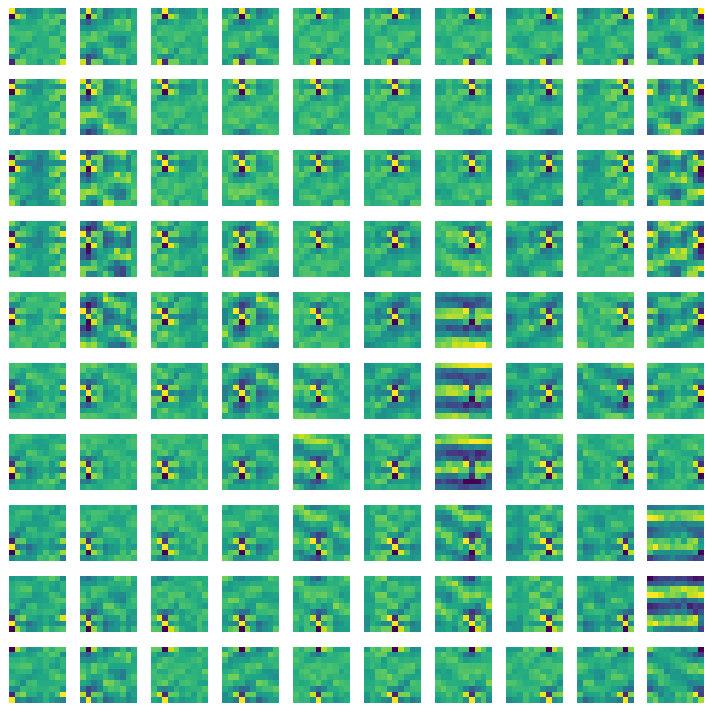

In [17]:

fc1 = augModel[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

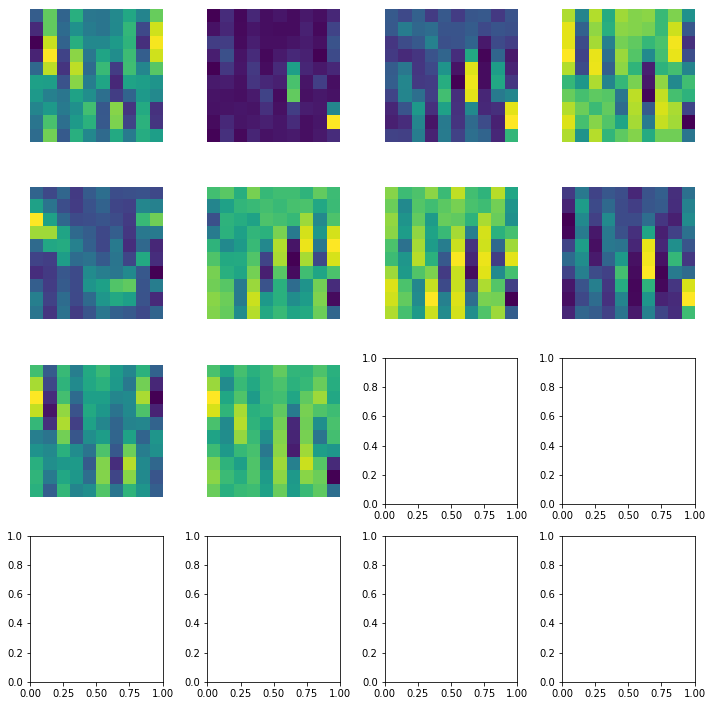

In [18]:

fc3 = augModel[len(augModel) - 1]
utils.helper.viewFCWeights(fc3)